[paper](https://arxiv.org/abs/1508.06576) [tutorial](http://www.chioka.in/tensorflow-implementation-neural-algorithm-of-artistic-style)

In [32]:
import os
import sys
import numpy as np
import scipy.io
import scipy.misc
import tensorflow as tf  # Import TensorFlow after Scipy or Scipy will break
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
%matplotlib inline

In [33]:
OUTPUT_DIR = 'output/'
STYLE_IMAGE = 'styles/guernica.jpg'
CONTENT_IMAGE = 'contents/hongkong.jpg'

IMAGE_WIDTH = 800
IMAGE_HEIGHT = 600
COLOR_CHANNELS = 3


NOISE_RATIO = 0.6
BETA = 5 ## content loss
ALPHA = 100 ## style loss
VGG_MODEL = '/Users/jasonxie/Downloads/imagenet-vgg-verydeep-19.mat'
MEAN_VALUES = np.array([123.68, 116.779, 103.939]).reshape((1,1,1,3))

In [34]:
def conv_layer(layer_name, layer_input, W):
    return tf.nn.conv2d(layer_input, W, strides=[1, 1, 1, 1], padding='SAME')
    
def relu_layer(layer_name, layer_input, b):
    return tf.nn.relu(layer_input + b)
    
def pool_layer(layer_name, layer_input):
    pool = tf.nn.avg_pool(layer_input, ksize=[1, 2, 2, 1], 
    strides=[1, 2, 2, 1], padding='SAME')
    return pool

def get_weights(vgg_layers, i):
    weights = vgg_layers[i][0][0][2][0][0]
    W = tf.constant(weights)
    return W

def get_bias(vgg_layers, i):
    bias = vgg_layers[i][0][0][2][0][1]
    b = tf.constant(np.reshape(bias, (bias.size)))
    return b

def build_model(modelPath):
    vgg_rawnet     = scipy.io.loadmat(modelPath)
    vgg_layers     = vgg_rawnet['layers'][0]

    net = {}
    net['input']   = tf.Variable(np.zeros((1, IMAGE_HEIGHT, IMAGE_WIDTH, COLOR_CHANNELS), dtype=np.float32))
    net['conv1_1'] = conv_layer('conv1_1', net['input'], W=get_weights(vgg_layers, 0))
    net['relu1_1'] = relu_layer('relu1_1', net['conv1_1'], b=get_bias(vgg_layers, 0))
    net['conv1_2'] = conv_layer('conv1_2', net['relu1_1'], W=get_weights(vgg_layers, 2))
    net['relu1_2'] = relu_layer('relu1_2', net['conv1_2'], b=get_bias(vgg_layers, 2))
    net['pool1']   = pool_layer('pool1', net['relu1_2'])

    net['conv2_1'] = conv_layer('conv2_1', net['pool1'], W=get_weights(vgg_layers, 5))
    net['relu2_1'] = relu_layer('relu2_1', net['conv2_1'], b=get_bias(vgg_layers, 5))
    net['conv2_2'] = conv_layer('conv2_2', net['relu2_1'], W=get_weights(vgg_layers, 7))
    net['relu2_2'] = relu_layer('relu2_2', net['conv2_2'], b=get_bias(vgg_layers, 7))
    net['pool2']   = pool_layer('pool2', net['relu2_2'])

    net['conv3_1'] = conv_layer('conv3_1', net['pool2'], W=get_weights(vgg_layers, 10))
    net['relu3_1'] = relu_layer('relu3_1', net['conv3_1'], b=get_bias(vgg_layers, 10))
    net['conv3_2'] = conv_layer('conv3_2', net['relu3_1'], W=get_weights(vgg_layers, 12))
    net['relu3_2'] = relu_layer('relu3_2', net['conv3_2'], b=get_bias(vgg_layers, 12))
    net['conv3_3'] = conv_layer('conv3_3', net['relu3_2'], W=get_weights(vgg_layers, 14))
    net['relu3_3'] = relu_layer('relu3_3', net['conv3_3'], b=get_bias(vgg_layers, 14))
    net['conv3_4'] = conv_layer('conv3_4', net['relu3_3'], W=get_weights(vgg_layers, 16))
    net['relu3_4'] = relu_layer('relu3_4', net['conv3_4'], b=get_bias(vgg_layers, 16))
    net['pool3']   = pool_layer('pool3', net['relu3_4'])

    net['conv4_1'] = conv_layer('conv4_1', net['pool3'], W=get_weights(vgg_layers, 19))
    net['relu4_1'] = relu_layer('relu4_1', net['conv4_1'], b=get_bias(vgg_layers, 19))
    net['conv4_2'] = conv_layer('conv4_2', net['relu4_1'], W=get_weights(vgg_layers, 21))
    net['relu4_2'] = relu_layer('relu4_2', net['conv4_2'], b=get_bias(vgg_layers, 21))
    net['conv4_3'] = conv_layer('conv4_3', net['relu4_2'], W=get_weights(vgg_layers, 23))
    net['relu4_3'] = relu_layer('relu4_3', net['conv4_3'], b=get_bias(vgg_layers, 23))
    net['conv4_4'] = conv_layer('conv4_4', net['relu4_3'], W=get_weights(vgg_layers, 25))
    net['relu4_4'] = relu_layer('relu4_4', net['conv4_4'], b=get_bias(vgg_layers, 25))
    net['pool4']   = pool_layer('pool4', net['relu4_4'])

    net['conv5_1'] = conv_layer('conv5_1', net['pool4'], W=get_weights(vgg_layers, 28))
    net['relu5_1'] = relu_layer('relu5_1', net['conv5_1'], b=get_bias(vgg_layers, 28))
    net['conv5_2'] = conv_layer('conv5_2', net['relu5_1'], W=get_weights(vgg_layers, 30))
    net['relu5_2'] = relu_layer('relu5_2', net['conv5_2'], b=get_bias(vgg_layers, 30))
    net['conv5_3'] = conv_layer('conv5_3', net['relu5_2'], W=get_weights(vgg_layers, 32))
    net['relu5_3'] = relu_layer('relu5_3', net['conv5_3'], b=get_bias(vgg_layers, 32))
    net['conv5_4'] = conv_layer('conv5_4', net['relu5_3'], W=get_weights(vgg_layers, 34))
    net['relu5_4'] = relu_layer('relu5_4', net['conv5_4'], b=get_bias(vgg_layers, 34))
    net['pool5']   = pool_layer('pool5', net['relu5_4'])

    return net

In [35]:
def content_loss_func(sess, model):
    """
    Content loss function as defined in the paper.
    """
    def _content_loss(p, x):
        # N is the number of filters (at layer l).
        N = p.shape[3]
        # M is the height times the width of the feature map (at layer l).
        M = p.shape[1] * p.shape[2]
        # Interestingly, the paper uses this form instead:
        #
        #   0.5 * tf.reduce_sum(tf.pow(x - p, 2)) 
        #
        # But this form is very slow in "painting" and thus could be missing
        # out some constants (from what I see in other source code), so I'll
        # replicate the same normalization constant as used in style loss.
        return (1 / (4 * N * M)) * tf.reduce_sum(tf.pow(x - p, 2))
    return _content_loss(sess.run(model['relu4_2']), model['relu4_2'])

# Layers to use. We will use these layers as advised in the paper.
# To have softer features, increase the weight of the higher layers
# (conv5_1) and decrease the weight of the lower layers (conv1_1).
# To have harder features, decrease the weight of the higher layers
# (conv5_1) and increase the weight of the lower layers (conv1_1).
STYLE_LAYERS = [
    ('relu1_1', 0.5),
    ('relu2_1', 1.0),
    ('relu3_1', 1.5),
    ('relu4_1', 3.0),
    ('relu5_1', 4.0),
]

def style_loss_func(sess, model):
    """
    Style loss function as defined in the paper.
    """
    def _gram_matrix(F, N, M):
        """
        The gram matrix G.
        """
        Ft = tf.reshape(F, (M, N))
        return tf.matmul(tf.transpose(Ft), Ft)

    def _style_loss(a, x):
        """
        The style loss calculation.
        """
        # N is the number of filters (at layer l).
        N = a.shape[3]
        # M is the height times the width of the feature map (at layer l).
        M = a.shape[1] * a.shape[2]
        # A is the style representation of the original image (at layer l).
        A = _gram_matrix(a, N, M)
        # G is the style representation of the generated image (at layer l).
        G = _gram_matrix(x, N, M)
        result = (1 / (4 * N**2 * M**2)) * tf.reduce_sum(tf.pow(G - A, 2))
        return result

    E = [_style_loss(sess.run(model[layer_name]), model[layer_name]) for layer_name, _ in STYLE_LAYERS]
    W = [w for _, w in STYLE_LAYERS]
    loss = sum([W[l] * E[l] for l in range(len(STYLE_LAYERS))])
    return loss

In [36]:
def generate_noise_image(content_image, noise_ratio = NOISE_RATIO):
    """
    Returns a noise image intermixed with the content image at a certain ratio.
    """
    noise_image = np.random.uniform(
            -20, 20,
            (1, IMAGE_HEIGHT, IMAGE_WIDTH, COLOR_CHANNELS)).astype('float32')
    # White noise image from the content representation. Take a weighted average
    # of the values
    input_image = noise_image * noise_ratio + content_image * (1 - noise_ratio)
    return input_image

def load_image(path):
    image = scipy.misc.imread(path)
    # Resize the image for convnet input, there is no change but just
    # add an extra dimension.
    image = np.reshape(image, ((1,) + image.shape))
    # Input to the VGG model expects the mean to be subtracted.
    image = image - MEAN_VALUES
    return image

def save_image(path, image):
    # Output should add back the mean.
    image = image + MEAN_VALUES
    # Get rid of the first useless dimension, what remains is the image.
    image = image[0]
    image = np.clip(image, 0, 255).astype('uint8')
    scipy.misc.imsave(path, image)

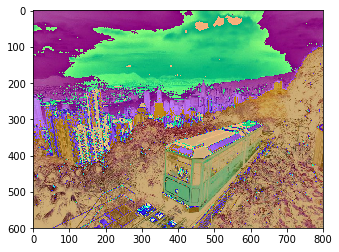

In [37]:
sess = tf.InteractiveSession()
content_image = load_image(CONTENT_IMAGE)
imshow(content_image[0])

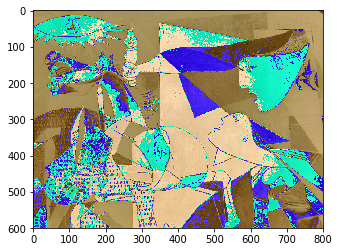

In [38]:
style_image = load_image(STYLE_IMAGE)
imshow(style_image[0])

In [39]:
model = build_model(VGG_MODEL)

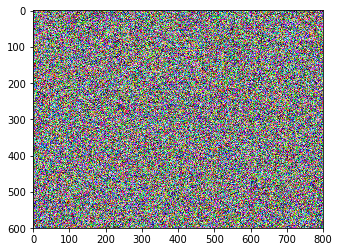

In [40]:
# Generate the white noise and content presentation mixed image
# which will be the basis for the algorithm to "paint".
input_image = generate_noise_image(content_image)
imshow(input_image[0])

In [41]:
sess.run(tf.initialize_all_variables())

sess.run(model['input'].assign(content_image))
content_loss = content_loss_func(sess, model)

sess.run(model['input'].assign(style_image))
style_loss = style_loss_func(sess, model)

## loss
total_loss = BETA * content_loss + ALPHA * style_loss

optimizer = tf.train.AdamOptimizer(2.0)
train_step = optimizer.minimize(total_loss)

Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [43]:
sess.run(tf.initialize_all_variables())
sess.run(model['input'].assign(input_image))

ITERATIONS = 100

sess.run(tf.initialize_all_variables())
sess.run(model['input'].assign(input_image))
for it in range(ITERATIONS):
    sess.run(train_step)
    if it%1 == 0:
        # Print every 100 iteration.
        mixed_image = sess.run(model['input'])
        print('Iteration %d' % (it))
        print('sum : ', sess.run(tf.reduce_sum(mixed_image)))
        print('cost: ', sess.run(total_loss))

        if not os.path.exists(OUTPUT_DIR):
            os.mkdir(OUTPUT_DIR)

        filename = 'output/%d.png' % (it)
        save_image(filename, mixed_image)

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Instructions for updating:
Use `tf.global_variables_initializer` instead.
Iteration 0
('sum : ', -4728126.5)
('cost: ', 0.0)
Iteration 1
('sum : ', -4728126.5)
('cost: ', 0.0)


KeyboardInterrupt: 

In [ ]:
save_image('output/art.jpg', mixed_image)